<a href="https://colab.research.google.com/github/VasundharaAgarwal/GANFingerprinting/blob/main/GAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
nnodes = 128*7*7
nz = 100
#learning rate for optimizers
lr = 0.0002
batch_size = 256
real_label = 1
fake_label = 0
num_epochs = 20
ngpu = 1
beta1 = 0.5
manualSeed = 500

torch.manual_seed(manualSeed)
random.seed(manualSeed)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size = batch_size)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [5]:
#weight initialization according to DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class Generator1(nn.Module):
  def __init__(self, ngpu):
      super(Generator1, self).__init__()
      self.ngpu = ngpu
      self.linear = nn.Linear(nz, nnodes, bias=True)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.convTr1 = nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.convTr2 = nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False)
      self.leakyReLU3 = nn.LeakyReLU(0.2)
      self.conv1 = nn.Conv2d(128, 1, 7, 1, 3, bias=False)

  def forward(self, x):
      x = self.linear(x.view(-1,1,1,100))
      x = self.leakyReLU1(x)
      x = x.view(-1,128, 7, 7)
      x = self.leakyReLU2(self.convTr1(x))
      x = self.leakyReLU3(self.convTr2(x))
      x = torch.sigmoid(self.conv1(x))
      return x


In [13]:
class Generator2(nn.Module):
  def __init__(self, ngpu):
    super(Generator2, self).__init__()
    self.ngpu = ngpu
    self.linear = nn.Linear(nz, nnodes, bias=True)
    self.leakyReLU1 = nn.LeakyReLU(0.2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.conv1 = nn.Conv2d(128, 128, 3, 1, 1, bias=False )
    self.leakyReLU2 = nn.LeakyReLU(0.2)
    self.conv2 = nn.Conv2d(128, 128, 3, 1, 1, bias=False )
    self.leakyReLU3 = nn.LeakyReLU(0.2)
    self.conv3 = nn.Conv2d(128, 1, 7, 1, 3, bias=False)

  def forward(self, x):
    x = self.linear(x.view(-1,1,1,100))
    x = self.leakyReLU1(x)
    x = x.view(-1, 128, 7, 7)
    x = self.leakyReLU2(self.conv1(self.upsample(x)))
    x = self.leakyReLU3(self.conv2(self.upsample(x)))
    x = torch.sigmoid(self.conv3(x))
    return x

In [40]:
class Generator3(nn.Module):
  def __init__(self, ngpu):
    super(Generator3, self).__init__()
    self.ngpu = ngpu
    self.linear = nn.Linear(nz, nnodes, bias=True)
    self.leakyReLU1 = nn.LeakyReLU(0.2)
    self.upsample = nn.Upsample(scale_factor=2)
    self.conv1 = nn.Conv2d(128, 64, 3, 1, 1, bias=False )
    self.leakyReLU2 = nn.LeakyReLU(0.2)
    self.conv2 = nn.Conv2d(64, 32, 3, 1, 1, bias=False )
    self.leakyReLU3 = nn.LeakyReLU(0.2)
    self.conv3 = nn.Conv2d(32, 1, 7, 1, 3, bias=False)

  def forward(self, x):
    x = self.linear(x.view(-1,1,1,100))
    x = self.leakyReLU1(x)
    x = x.view(-1, 128, 7, 7)
    x = self.leakyReLU2(self.conv1(self.upsample(x)))
    x = self.leakyReLU3(self.conv2(self.upsample(x)))
    x = torch.sigmoid(self.conv3(x))
    return x

In [8]:
class Discriminator1(nn.Module):
  def __init__(self, ngpu):
      super(Discriminator1, self).__init__()
      self.ngpu = ngpu
      self.conv1 = nn.Conv2d(1, 64, 3, 2, 1, bias=False)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.dropout1 = nn.Dropout(0.4)
      self.conv2 = nn.Conv2d(64, 64, 3, 2, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.dropout2 = nn.Dropout(0.4)
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(3136, 1, bias=True)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout1(self.leakyReLU1(x))
      x = self.conv2(x)
      x = self.dropout2(self.leakyReLU2(x))
      x = self.sigmoid(self.linear(self.flatten(x)))
      return x



In [10]:
class Discriminator2(nn.Module):
  def __init__(self, ngpu):
      super(Discriminator2, self).__init__()
      self.ngpu = ngpu
      self.conv1 = nn.Conv2d(1, 64, 3, 1, 1, bias=False)
      self.maxpool2d = nn.MaxPool2d(3, 2, 1)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.dropout1 = nn.Dropout(0.4)
      self.conv2 = nn.Conv2d(64, 64, 3, 1, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.dropout2 = nn.Dropout(0.4)
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(3136, 1, bias=True)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.maxpool2d(self.conv1(x))
      x = self.dropout1(self.leakyReLU1(x))
      x = self.maxpool2d(self.conv2(x))
      x = self.dropout2(self.leakyReLU2(x))
      x = self.sigmoid(self.linear(self.flatten(x)))
      return x

In [50]:
class Discriminator3(nn.Module):
  def __init__(self, ngpu):
      super(Discriminator3, self).__init__()
      self.ngpu = ngpu
      self.conv1 = nn.Conv2d(1, 64, 3, 1, 1, bias=False)
      self.avgpool2d = nn.AvgPool2d(3, 2, 1)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.dropout1 = nn.Dropout(0.4)
      self.conv2 = nn.Conv2d(64, 64, 3, 1, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.dropout2 = nn.Dropout(0.4)
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(3136, 1, bias=True)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.avgpool2d(self.conv1(x))
      x = self.dropout1(self.leakyReLU1(x))
      x = self.avgpool2d(self.conv2(x))
      x = self.dropout2(self.leakyReLU2(x))
      x = self.sigmoid(self.linear(self.flatten(x)))
      return x

In [9]:
criterion = nn.BCELoss()

#fixed noise used to visualize performance of GAN as it progresses through training
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.



In [18]:
#slightly edited the code at https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def trainGAN(num, netG, netD):
  netG = netG.to(device)
  netD = netD.to(device)
  optimD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
  img_list = []
  D_x_list = []
  D_G_z1_list = []
  D_G_z2_list = []
  iters = 0
  for epoch in range(num_epochs):
      print(epoch)
      # For each batch in the dataloader
      for i, data in enumerate(train_loader, 0):

          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          ## Train with all-real batch
          netD.zero_grad()
          # Format batch
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          # Forward pass real batch through D
          output = netD(real_cpu).view(-1)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward()
          D_x = output.mean().item()

          ## Train with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(b_size, nz, 1, 1, device=device)
          # Generate fake image batch with G
          fake = netG(noise)
          label.fill_(fake_label)
          # Classify all fake batch with D
          output = netD(fake.detach()).view(-1)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Add the gradients from the all-real and all-fake batches
          errD = errD_real + errD_fake
          # Update D
          optimD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake).view(-1)
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimG.step()

          # Output training stats
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          # Save Losses for plotting later
          D_x_list.append(D_x)
          D_G_z1_list.append(D_G_z1)
          D_G_z2_list.append(D_G_z2)
          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
          iters += 1

  torch.save({
            'G_state_dict': netG.state_dict(),
            'D_state_dict': netD.state_dict(),
            'optimG_state_dict': optimG.state_dict(),
            'optimD_state_dict': optimD.state_dict(),
            'img_list': img_list,
            'D_x_list': D_x_list,
            'D_G_z1_list' : D_G_z1_list,
            'D_G_z2_list' : D_G_z2_list,
            }, 'gdrive/My Drive/GAN_{}'.format(num))


In [55]:
trainGAN(0, Generator1(ngpu), Discriminator1(ngpu))



0
[0/20][0/235]	Loss_D: 1.3800	Loss_G: 0.6964	D(x): 0.5124	D(G(z)): 0.5088 / 0.4985
[0/20][50/235]	Loss_D: 0.7329	Loss_G: 0.6964	D(x): 0.9588	D(G(z)): 0.4985 / 0.4984
[0/20][100/235]	Loss_D: 0.6938	Loss_G: 0.7026	D(x): 0.9903	D(G(z)): 0.4953 / 0.4953
[0/20][150/235]	Loss_D: 0.6825	Loss_G: 0.7085	D(x): 0.9957	D(G(z)): 0.4924 / 0.4924
[0/20][200/235]	Loss_D: 0.6740	Loss_G: 0.7140	D(x): 0.9988	D(G(z)): 0.4897 / 0.4897
1
[1/20][0/235]	Loss_D: 0.8306	Loss_G: 0.8019	D(x): 0.7973	D(G(z)): 0.4509 / 0.4489
[1/20][50/235]	Loss_D: 0.7409	Loss_G: 0.6966	D(x): 0.9676	D(G(z)): 0.5015 / 0.5010
[1/20][100/235]	Loss_D: 0.9580	Loss_G: 0.6561	D(x): 0.8563	D(G(z)): 0.5323 / 0.5266
[1/20][150/235]	Loss_D: 1.0003	Loss_G: 0.6748	D(x): 0.7705	D(G(z)): 0.5187 / 0.5101
[1/20][200/235]	Loss_D: 1.3968	Loss_G: 0.6086	D(x): 0.5567	D(G(z)): 0.5484 / 0.5455
2
[2/20][0/235]	Loss_D: 1.2293	Loss_G: 0.6825	D(x): 0.6311	D(G(z)): 0.5248 / 0.5109
[2/20][50/235]	Loss_D: 1.3695	Loss_G: 0.6690	D(x): 0.5232	D(G(z)): 0.5072 / 0.

In [22]:
manualSeed = 650

torch.manual_seed(manualSeed)
random.seed(manualSeed)


trainGAN(2, Generator2(ngpu), Discriminator2(ngpu))

0
[0/20][0/235]	Loss_D: 1.3233	Loss_G: 0.7473	D(x): 0.5222	D(G(z)): 0.4883 / 0.4744


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[0/20][50/235]	Loss_D: 1.1041	Loss_G: 0.5851	D(x): 0.7695	D(G(z)): 0.5646 / 0.5593
[0/20][100/235]	Loss_D: 1.2703	Loss_G: 0.8562	D(x): 0.6971	D(G(z)): 0.5723 / 0.4369
[0/20][150/235]	Loss_D: 1.0572	Loss_G: 0.7485	D(x): 0.7088	D(G(z)): 0.4995 / 0.4794
[0/20][200/235]	Loss_D: 1.0500	Loss_G: 0.8312	D(x): 0.7047	D(G(z)): 0.4834 / 0.4449
1
[1/20][0/235]	Loss_D: 0.8263	Loss_G: 0.9136	D(x): 0.7913	D(G(z)): 0.4235 / 0.4149
[1/20][50/235]	Loss_D: 0.9286	Loss_G: 1.0402	D(x): 0.7356	D(G(z)): 0.4301 / 0.3767
[1/20][100/235]	Loss_D: 1.1277	Loss_G: 0.6634	D(x): 0.7250	D(G(z)): 0.5213 / 0.5277
[1/20][150/235]	Loss_D: 1.2365	Loss_G: 0.7002	D(x): 0.6115	D(G(z)): 0.4886 / 0.5132
[1/20][200/235]	Loss_D: 1.2088	Loss_G: 0.7198	D(x): 0.6462	D(G(z)): 0.4992 / 0.5037
2
[2/20][0/235]	Loss_D: 1.2037	Loss_G: 0.7321	D(x): 0.5838	D(G(z)): 0.4497 / 0.4962
[2/20][50/235]	Loss_D: 1.2096	Loss_G: 0.6753	D(x): 0.6163	D(G(z)): 0.4879 / 0.5206
[2/20][100/235]	Loss_D: 1.2283	Loss_G: 0.7048	D(x): 0.6751	D(G(z)): 0.5445 / 0.

In [56]:
#plt.figure(figsize=(10,5))
#plt.title("Generator and Discriminator Loss During Training")
#plt.plot(G_losses,label="G")
#plt.plot(D_losses,label="D")
#plt.xlabel("iterations")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()
#len(G_losses)

In [57]:
#import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#from IPython.display import HTML
#import numpy as np

#fig = plt.figure(figsize=(8,8))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())

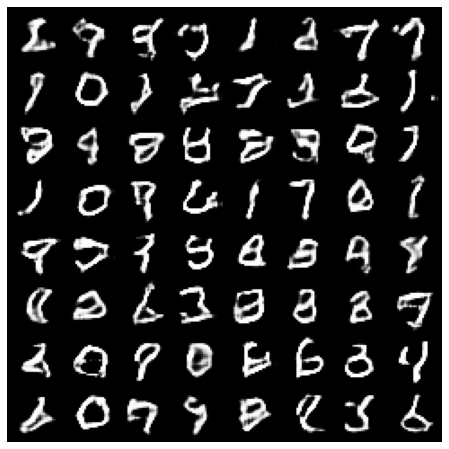

In [52]:
checkpoint = torch.load('gdrive/My Drive/GAN_1')
img_list = checkpoint['img_list']
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


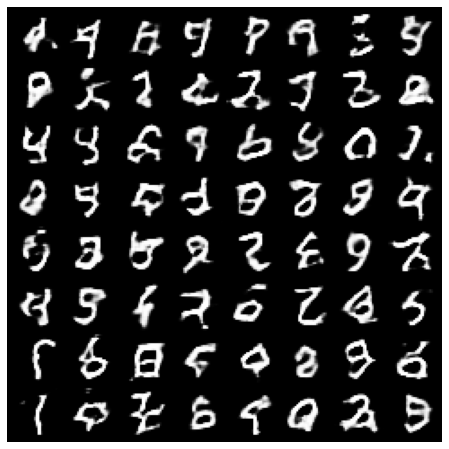

In [43]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


In [41]:
manualSeed = 5405

torch.manual_seed(manualSeed)
random.seed(manualSeed)


trainGAN(1, Generator3(ngpu), Discriminator2(ngpu))

0
[0/20][0/235]	Loss_D: 1.4133	Loss_G: 0.7040	D(x): 0.4931	D(G(z)): 0.5062 / 0.4947
[0/20][50/235]	Loss_D: 0.7185	Loss_G: 0.7078	D(x): 0.9619	D(G(z)): 0.4928 / 0.4927
[0/20][100/235]	Loss_D: 0.7036	Loss_G: 0.6968	D(x): 0.9906	D(G(z)): 0.4994 / 0.4988
[0/20][150/235]	Loss_D: 0.7339	Loss_G: 0.7201	D(x): 0.9364	D(G(z)): 0.4866 / 0.4869
[0/20][200/235]	Loss_D: 0.7823	Loss_G: 0.6752	D(x): 0.9724	D(G(z)): 0.5166 / 0.5141
1
[1/20][0/235]	Loss_D: 0.8874	Loss_G: 0.6639	D(x): 0.9155	D(G(z)): 0.5287 / 0.5224
[1/20][50/235]	Loss_D: 1.1316	Loss_G: 0.6534	D(x): 0.6887	D(G(z)): 0.5283 / 0.5216
[1/20][100/235]	Loss_D: 1.2908	Loss_G: 0.6144	D(x): 0.6402	D(G(z)): 0.5559 / 0.5498
[1/20][150/235]	Loss_D: 1.3348	Loss_G: 0.5696	D(x): 0.6289	D(G(z)): 0.5727 / 0.5698
[1/20][200/235]	Loss_D: 1.3780	Loss_G: 0.5952	D(x): 0.5848	D(G(z)): 0.5609 / 0.5541
2
[2/20][0/235]	Loss_D: 1.3490	Loss_G: 0.6457	D(x): 0.5743	D(G(z)): 0.5428 / 0.5266
[2/20][50/235]	Loss_D: 1.3576	Loss_G: 0.6896	D(x): 0.5055	D(G(z)): 0.4849 / 0.

In [51]:
manualSeed = 5405

torch.manual_seed(manualSeed)
random.seed(manualSeed)


trainGAN(1, Generator3(ngpu), Discriminator3(ngpu))

0
[0/20][0/235]	Loss_D: 1.4090	Loss_G: 0.7040	D(x): 0.4936	D(G(z)): 0.5048 / 0.4946
[0/20][50/235]	Loss_D: 0.7613	Loss_G: 1.5243	D(x): 0.6242	D(G(z)): 0.2489 / 0.2193
[0/20][100/235]	Loss_D: 0.7447	Loss_G: 0.7127	D(x): 0.9330	D(G(z)): 0.4904 / 0.4903
[0/20][150/235]	Loss_D: 0.7568	Loss_G: 0.6825	D(x): 0.9758	D(G(z)): 0.5104 / 0.5089
[0/20][200/235]	Loss_D: 1.7121	Loss_G: 0.5336	D(x): 0.5886	D(G(z)): 0.6519 / 0.6011
1
[1/20][0/235]	Loss_D: 1.3050	Loss_G: 0.6538	D(x): 0.5757	D(G(z)): 0.5222 / 0.5233
[1/20][50/235]	Loss_D: 1.4143	Loss_G: 0.6512	D(x): 0.5266	D(G(z)): 0.5290 / 0.5278
[1/20][100/235]	Loss_D: 1.3035	Loss_G: 0.6507	D(x): 0.5870	D(G(z)): 0.5335 / 0.5239
[1/20][150/235]	Loss_D: 1.3028	Loss_G: 0.6166	D(x): 0.5801	D(G(z)): 0.5284 / 0.5412
[1/20][200/235]	Loss_D: 1.3880	Loss_G: 0.5982	D(x): 0.5566	D(G(z)): 0.5476 / 0.5514
2
[2/20][0/235]	Loss_D: 1.3794	Loss_G: 0.6684	D(x): 0.5374	D(G(z)): 0.5292 / 0.5138
[2/20][50/235]	Loss_D: 1.4170	Loss_G: 0.5934	D(x): 0.5465	D(G(z)): 0.5545 / 0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')